In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
# accessing data from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading the dataset
data = pd.read_csv('/content/drive/MyDrive/AIP Team 5/new_data.csv')

# first 5 samples from dataset
data.head()

,comment,label,processed_text,comment_len,processed_text_len
0,Mohammad harun he is an awesome guy very info...,1,mohammad harun awesome guy informative helpful...,44,22.0
1,amazing guy gaurav was so patience and kind ...,1,amazing guy gaurav patience kind helped start ...,55,27.0
2,Gaurav was very knowledgeable and very helpful...,1,gaurav knowledgeable helpful knows situation a...,36,17.0
3,I called them regarding my flight cancellation...,1,i called regarding flight cancellation narrate...,34,19.0
4,VERY GOOD SERVICE BY GAURAV LOHAT SERVED AS SO...,1,very good service by gaurav lohat served as so...,23,23.0


In [ ]:
# converting comments into lowercase
data['processed_text'] = data['processed_text'].str.lower()

In [ ]:
# data['label'] = data['label'].apply(lambda x: 1 if x=='Postive' else 0)

In [ ]:
# spliting 30000 positive random samples
df_train_pos = data[data['label']==1].sample(30000, random_state=13)
df_test_pos = data[data['label']==1].drop(df_train_pos.index)

# spliting 20000 negative random samples
df_train_neg = data[data['label']==0].sample(20000, random_state=13)
df_test_neg = data[data['label']==0].drop(df_train_neg.index)

# joining negative and positive samples for train and test
df_train = pd.concat([df_train_pos,df_train_neg])
df_test = pd.concat([df_test_pos,df_test_neg])


In [ ]:
# # 5k ssample dataset for trials
# df_5k = df_train.sample(5000,random_state=13)
# X_train = df_5k['processed_text']
# y_train = df_5k['label']

# df_2k = df_train.sample(2000,random_state=13)
# X_test = df_2k['processed_text']
# y_test = df_2k['label']


In [ ]:
# creating X and y for train and test
X_train = df_train['processed_text']
y_train = df_train['label']

X_test = df_test['processed_text']
y_test = df_test['label']


In [ ]:
# number of samples in train and test for each class
y_test.value_counts(),y_train.value_counts()

(1    245522
 0      8459
 Name: label, dtype: int64,
 1    30000
 0    20000
 Name: label, dtype: int64)

In [ ]:
# creating words dictionary 
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
dic = vectorizer.fit_transform(X_train)

num_words = len(vectorizer.vocabulary_)
num_words

28005

In [ ]:
# Making the embedding layer using pre-trained weights, taken from Glove
embedding_dict = {}

glove_file_path = r"/content/drive/MyDrive/Sem 3/Deep Learning/glove.6B.100d.txt"
with open(glove_file_path,'r') as f:
    for line in f:

        # Every lines contains word and then its embedding
        # spliting the line
        values = line.split()

        # first token will be the word
        word = values[0]

        # rest of the tokens are the embedding values of that word
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors
        
f.close()

In [ ]:
# from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
num_words = len(vectorizer.vocabulary_)

tokenizer = Tokenizer(num_words=num_words)

# encoding the words to numbers
tokenizer.fit_on_texts(X_train)
X_train_encoding = tokenizer.texts_to_sequences(X_train)
X_test_encoding = tokenizer.texts_to_sequences(X_test)

max_review_length = 70

# using padding to make every review of equal size
X_train = pad_sequences(X_train_encoding, maxlen=max_review_length,padding='post')
X_test = pad_sequences(X_test_encoding, maxlen=max_review_length,padding='post')

words_to_index = tokenizer.word_index

In [ ]:
X_train[0]

array([    1,   223,   324,     1,    90,    37,   179,     1,  1190,
          19,    15,  1405,   195,   242,    15,     1,    34,   162,
         383,    26,    12,   801,  1243,    15,   565,     1,  1021,
         181,    37,  1978,   381,    15,   153,   363, 10203,  1835,
         837,  2104,  1109,   186,   113,   901,   420,     1,   197,
         252,    84,  1557,   160,   108,   817,   242,     1,  5832,
           6,   537,   139,   233,   578,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0], dtype=int32)

In [ ]:
# length of our vocab
vocab_len = len(words_to_index)+1

# defining the numpy matrix to store the encodings
emb_matrix = np.zeros((vocab_len, 100))

not_list = []
for word, index in words_to_index.items():
  embedding_vector = embedding_dict.get(word)

  # if word is in the embedding dictionary else discard it
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector
  else:
    not_list.append(index)

embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_len, output_dim=100, input_length=max_review_length, weights = [emb_matrix], trainable=True)

In [ ]:
import tensorflow as tf

# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 24

# Build the model
model = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim,return_sequences=True,dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim,return_sequences=True,dropout=0.2)),
    tf.keras.layers.LSTM(lstm_dim,dropout=0.2),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 100)           2804200   
                                                                 
 bidirectional (Bidirectiona  (None, 70, 64)           34048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 70, 64)           24832     
 nal)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dropout (Dropout)           (None, 24)                0

In [ ]:
NUM_EPOCHS = 20

# Train the model
history_lstm = model.fit(X_train,y_train, epochs=NUM_EPOCHS)

Epoch 1/20
1563/1563 [==============================] - 111s 61ms/step - loss: 0.3799 - accuracy: 0.8504
Epoch 2/20
1563/1563 [==============================] - 41s 26ms/step - loss: 0.3096 - accuracy: 0.8839
Epoch 3/20
1563/1563 [==============================] - 34s 22ms/step - loss: 0.2827 - accuracy: 0.8952
Epoch 4/20
1563/1563 [==============================] - 35s 22ms/step - loss: 0.2639 - accuracy: 0.9020
Epoch 5/20
1563/1563 [==============================] - 35s 22ms/step - loss: 0.2375 - accuracy: 0.9107
Epoch 6/20
1563/1563 [==============================] - 33s 21ms/step - loss: 0.2195 - accuracy: 0.9191
Epoch 7/20
1563/1563 [==============================] - 34s 22ms/step - loss: 0.2036 - accuracy: 0.9256
Epoch 8/20
1563/1563 [==============================] - 32s 20ms/step - loss: 0.1882 - accuracy: 0.9303
Epoch 9/20
1563/1563 [==============================] - 31s 20ms/step - loss: 0.1789 - accuracy: 0.9330
Epoch 10/20
1563/1563 [==============================] - 32s 21

In [ ]:
# model.save('/content/drive/MyDrive/AIP Team 5/dataset/new_data_lstm_glove')

In [ ]:
prediction = model.predict(X_test)

7937/7937 [==============================] - 87s 11ms/step


<Axes: ylabel='Count'>

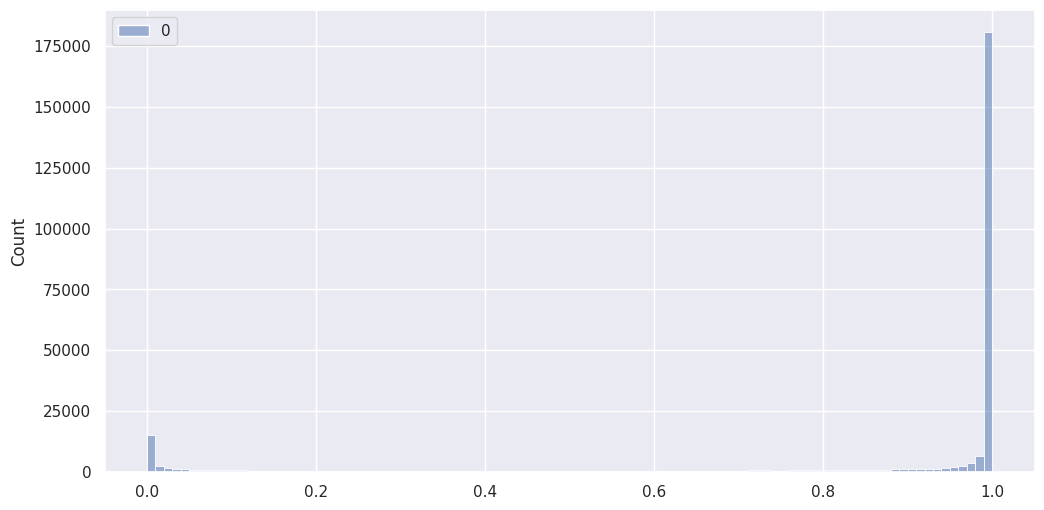

In [ ]:
sns.set(rc={"figure.figsize":(12, 6)}) #width=12, height=6

sns.histplot(prediction,bins=100)

In [ ]:
type(df_test.index),np.array(df_test.index)

(pandas.core.indexes.numeric.Int64Index,
 array([     0,      1,      2, ..., 303966, 303977, 303980]))

In [ ]:
# sns.set(rc={"figure.figsize":(16, 8)}) 

# sns.scatterplot(x=np.array(df_test.index),y=prediction.reshape(-1))

In [ ]:
y_pred = (prediction > 0.5)

Accuracy of the model :  0.880117016627228
F1-score:  0.9344211451315539


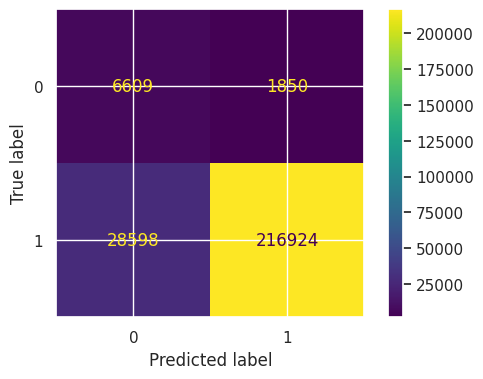

In [ ]:
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix,recall_score,precision_score,ConfusionMatrixDisplay

print("Accuracy of the model : ", accuracy_score(y_pred, y_test))
print('F1-score: ', f1_score(y_pred, y_test))
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['0','1'])
sns.set(rc={"figure.figsize":(6, 4)})
disp.plot()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['Positive','Negative']))

              precision    recall  f1-score   support

    Positive       0.19      0.78      0.30      8459
    Negative       0.99      0.88      0.93    245522

    accuracy                           0.88    253981
   macro avg       0.59      0.83      0.62    253981
weighted avg       0.96      0.88      0.91    253981



In [ ]:
6951/8459, 212444/245522

(0.8217283366828231, 0.8652748022580461)

In [ ]:
df_test['prediction'] = y_pred

In [ ]:
# df[(df['y_test']==0) & (df['y_pred']==True)]

In [ ]:
df_test[['comment','label']][(df_test['prediction'] == True ) & (df_test['label'] == 0)]

,comment,label
275543,Can t get them to call back,0
275558,I had given one star to Tripfur because there ...,0
275574,Pathetic customer service especially by Neha ...,0
275586,This company is THE WORST EVER Total scam ...,0
275616,Did everything on line with no difficulty,0
...,...,...
303939,I uesd the apl on my phone and instead of la...,0
303945,Agent not experienced enough to advise that if...,0
303951,card put on hold they though it was fraud talk...,0
303957,JustFly s policy is to charge to cancel a ...,0


In [ ]:
df_test['processed_text_len'][(df_test['prediction'] == True ) & (df_test['label'] == 0)].describe()

count    1850.000000
mean       34.681081
std        40.361146
min         1.000000
25%        11.000000
50%        21.500000
75%        41.000000
max       289.000000
Name: processed_text_len, dtype: float64

In [ ]:
prediction = model.predict(X_train)
y_pred = (prediction > 0.5)

1563/1563 [==============================] - 12s 8ms/step


In [ ]:
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix,recall_score,precision_score

print("Accuracy of the model : ", accuracy_score(y_pred, y_train))
print('F1-score: ', f1_score(y_pred, y_train))
print('Confusion matrix:')
confusion_matrix(y_train,y_pred)

Accuracy of the model :  0.9841
F1-score:  0.9868196362551188
Confusion matrix:


array([[19444,   556],
       [  239, 29761]])